In [6]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from networkx.drawing.nx_agraph import graphviz_layout

In [5]:
class Vertex:
    
    def __init__(self, index: int, name=None, data=None):
        self.id = index
        self.name = name
        self.data = data
        self.neighbors = {}
        
        # Can be used in Dijkstra's algorithm etc.
        self.weight = None
        
        # DFS features
        self.pre = None
        self.post = None
        
    def to_dict(self):
        return {'index': self.id, 'name': self.name, 'data': self.data}
        
    def __repr__(self):
        return f'Vertex(id={self.id}, weight={self.weight})'
        
    def __eq__(self, other):
        return True if self.weight == other.weight else False
    
    def __ne__(self, other):
        return True if self.weight != other.weight else False
    
    def __gt__(self, other):
        return True if self.weight > other.weight else False
    
    def __ge__(self, other):
        return True if self.weight >= other.weight else False
    
    def __lt__(self, other):
        return True if self.weight < other.weight else False
    
    def __le__(self, other):
        return True if self.weight <= other.weight else False

In [24]:
class Graph:
    
    def __init__(self):
        self.vertex_list = {}
    
    def add_vertex(self, index: int, name=None, data=None):
        new_vertex = Vertex(index, name, data)
        self.vertex_list[index] = new_vertex
        return new_vertex
    
    def add_edge(self, edge, weight=1):
        for v in edge:
            if v not in self.vertex_list:
                self.add_vertex(v)
                
        i, j = edge
        v1, v2 = self.vertex_list[i], self.vertex_list[j]
        v1.neighbors[j] = weight
        v2.neighbors[i] = weight
        
    def compute_edge_list(self, vertex_id_list=None):
        if vertex_id_list is None:
            vertex_list = self.vertex_list
        else:
            vertex_list = {i: self.vertex_list[i] for i in vertex_id_list}
            
        edge_list = {}
        for i, vert in vertex_list.items():
            for j, weight in vert.neighbors.items():
                edge_list[(i, j)] = weight
                
        return edge_list
                
    def is_acyclic(self):
        self.clock = 0
        checked_vertices = set()
        for i in self.vertex_list:
            if i in checked_vertices:
                continue
            connectivity_comp = self.dfs(i, visited_set=checked_vertices)
            edge_list = self.compute_edge_list(vertex_id_list=connectivity_comp)
            for i, j in edge_list:
                u, v = self.vertex_list[i], self.vertex_list[j]
                if v.pre < u.pre and v.post > u.post:
                    return False
        return True
                
    def full_dfs(self):
        self.clock = 0
        checked_vertices = set()
        for i in self.vertex_list:
            if i in checked_vertices:
                continue
            connectivity_comp = self.dfs(i, visited_set=checked_vertices)
        
    def dfs(self, vertex_id, visited_set=None):
        if visited_set is None:
            visited_set = set()
            self.clock = 0
        visited_set.add(vertex_id)
        vertex = self.vertex_list[vertex_id]
        #previsit
        vertex.pre = self.clock
        self.clock += 1
        
        for neighbor_id in vertex.neighbors:
            if neighbor_id not in visited_set:
                # print(f'from {str(vertex_id):<3} go to {neighbor_id}')
                self.dfs(neighbor_id, visited_set)
        # postvisit
        vertex.post = self.clock
        self.clock += 1
        
        return visited_set
    
    def bfs(self, vertex_id):
        path_lengths = {vertex_id: 0}
        queue = [vertex_id]
        visited_set = {vertex_id}
        while queue:
            vert_id = queue.pop(0)
            # print(f'pop {vert_id}')
            neighbors = self.vertex_list[vert_id].neighbors
            for neighbor_id in neighbors:
                if neighbor_id not in visited_set:
                    weight = neighbors[neighbor_id]
                    path_lengths[neighbor_id] = path_lengths[vert_id] + weight
                    # print(f'append {neighbor_id}')
                    queue.append(neighbor_id)
                    visited_set.add(neighbor_id)
                    
        return path_lengths
    
    def dijkstra(self, vertex_id):
        vertex = self.vertex_list[vertex_id]
        for ind, vert in self.vertex_list.items():
            vert.weight = float('inf') if ind != vertex_id else 0
            
        min_heap = BinHeap([vertex], get_id=lambda vert: vert.id)
        visited_set = {vertex_id}
        path_lengths = {}
        while min_heap:
            next_vert = min_heap.extract_min()
            visited_set.add(next_vert.id)
            path_lengths[next_vert.id] = next_vert.weight
            
            neighbors = ((self.vertex_list[vertex_id], weight) for vertex_id, weight in next_vert.neighbors.items())
            for neighbor, edge_weight in neighbors:
                assert edge_weight >= 0
                if neighbor.id in visited_set:
                    continue
                elif neighbor not in min_heap:
                    neighbor.weight = next_vert.weight + edge_weight
                    min_heap.insert(neighbor)
                elif next_vert.weight + edge_weight < neighbor.weight:
                    neighbor.weight = next_vert.weight + edge_weight
                    min_heap.bubble_up(min_heap.get_index(neighbor))
                    
        return path_lengths
    
    def bellman_ford(self, vertex_id):
        path_lengths = {key: float('inf') for key in self.vertex_list}
        path_lengths[vertex_id] = 0
        edge_list = self.compute_edge_list()
        for _ in range(len(self.vertex_list)):
            update_count = 0
            for (i, j), weight in edge_list.items():
                if path_lengths[j] > path_lengths[i] + weight:
                    path_lengths[j] = path_lengths[i] + weight
                    update_count += 1
            if not update_count:
                break
                
        if update_count:
            raise Exception('Negative Circle detected!')
                
        return path_lengths
    
    
class DiGraph(Graph):
    
    def add_edge(self, edge, weight=1):
        for v in edge:
            if v not in self.vertex_list:
                self.add_vertex(v)
                
        i, j = edge
        self.vertex_list[i].neighbors[j] = weight
        
    def topoligical_sorting(self):
        assert self.is_acyclic() # "post" values are computed here
        
        def vertex_post(vertex_id):
            return self.vertex_list[vertex_id].post
        
        return sorted(self.vertex_list, key=vertex_post, reverse=True)
    
    def post_sorting(self):
        self.full_dfs() # "post" values are computed here
        
        def vertex_post(vertex_id):
            return self.vertex_list[vertex_id].post
        
        return sorted(self.vertex_list, key=vertex_post, reverse=True)
    
    def get_reversed_graph(self):
        G_reversed = DiGraph()
        for vert in self.vertex_list.values():
            G_reversed.add_vertex(**vert.to_dict())
        for (i, j), weight in self.compute_edge_list().items():
            G_reversed.add_edge((j, i), weight)
        return G_reversed
    
    def get_strongly_connected_components(self):
        G_reversed = self.get_reversed_graph()
        post_ordering = G_reversed.post_sorting()
        
        self.clock = 0
        checked_vertices = set()
        strongly_connected_components = []
        for i in post_ordering:
            if i in checked_vertices:
                continue
            strongly_connected_component = self.dfs(i, visited_set=checked_vertices)
            strongly_connected_components.append(strongly_connected_component)
            
        return strongly_connected_components

In [5]:
# Testing Bipartiteness

class BipartGraph(Graph):
    
    def is_bipartite(self):
        color_map = {}
        for vertex_id in self.vertex_list:
            if vertex_id in color_map:
                continue
            color_map = {vertex_id: True}
            queue = [vertex_id]
            visited_set = {vertex_id}
            while queue:
                vert_id = queue.pop(0)
                # print(f'pop {vert_id}')
                neighbors = self.vertex_list[vert_id].neighbors
                for neighbor_id in neighbors:
                    if neighbor_id in color_map and color_map[neighbor_id] == color_map[vert_id]:
                        return False
                    if neighbor_id not in visited_set:
                        weight = neighbors[neighbor_id]
                        color_map[neighbor_id] = not color_map[vert_id]
                        # print(f'append {neighbor_id}')
                        queue.append(neighbor_id)
                        visited_set.add(neighbor_id)
        return True
    

# with open('/home/hamit/Downloads/rosalind_bip (2).txt', 'r') as input_file:
#     k = int(input_file.readline().strip())
#     for i in range(k):
#         g = BipartGraph()
#         G = nx.Graph()
#         assert input_file.readline() == '\n'
#         n, m = map(int, input_file.readline().split())
#         [g.add_vertex(i+1) for i in range(n)]    
#         for _ in range(m):
#             line = input_file.readline()
#             edge = tuple(map(int, line.split()))
#             if edge:
#                 g.add_edge(edge)
#                 G.add_edge(*edge)
            
#         # print(1 if g.is_bipartite() else -1, end=' ')
#         print(i, g.is_bipartite(), nx.is_bipartite(G))

In [205]:
# Testing Acyclicity

class CycleDetected(Exception):
    pass

class AcyclicGraph(DiGraph):
    
    def dfs_cycle_check(self, vertex_id, global_visited_set, visited_set=None, leaved_set=None):
        if visited_set is None:
            visited_set = set()
            leaved_set = set()
        visited_set.add(vertex_id)
        for neighbor_id in self.vertex_list[vertex_id].neighbors:
            # print(f'from {str(vertex_id):<3} go to {neighbor_id}')
            if neighbor_id in visited_set and neighbor_id not in leaved_set:
                raise CycleDetected
            elif neighbor_id not in global_visited_set:
                self.dfs_cycle_check(neighbor_id, global_visited_set, visited_set, leaved_set)
        leaved_set.add(vertex_id)
        
        return visited_set
    
    def is_acyclic(self):
        global_visited_set = set()
        for vertex_id in self.vertex_list:
            if vertex_id not in global_visited_set:
                try:
                    global_visited_set |= self.dfs_cycle_check(
                        vertex_id, 
                        global_visited_set
                    )
                except CycleDetected:
                    return False
        return True
    

with open('/home/hamit/Downloads/rosalind_dag.txt', 'r') as input_file:
    k = int(input_file.readline().strip())
    # k = 1
    for i in range(k):
        # g = AcyclicGraph()
        g = DiGraph()
        # G = nx.DiGraph()
        assert input_file.readline() == '\n'
        n, m = map(int, input_file.readline().split())
        [g.add_vertex(i+1) for i in range(n)]
        for _ in range(m):
            line = input_file.readline()
            edge = tuple(map(int, line.split()))
            if edge:
                g.add_edge(edge)
                # G.add_edge(*edge)
                
        print(-1 if g.is_acyclic() else 1, end=' ')
            
        # flag = False
        # try:
        #     nx.find_cycle(G)
        # except:
        #     flag = True
        # print(i, g.is_acyclic(), flag)
        


1 -1 1 -1 1 1 -1 -1 1 1 1 -1 1 -1 1 -1 1 -1 -1 

In [ ]:
1 -1 1 -1 1 1 -1 -1 1 1 1 -1 1 -1 1 -1 1 -1 -1 

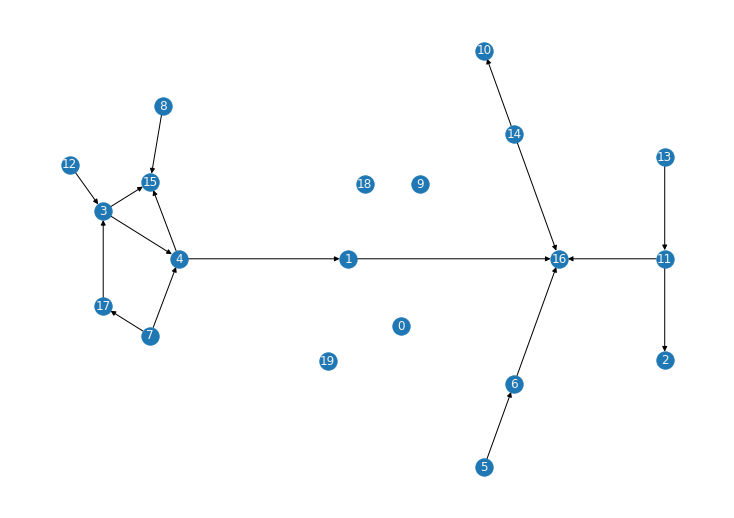

In [392]:
# Tests generator

N = 20
p = 0.05
G = nx.fast_gnp_random_graph(N, p, seed=0, directed=True)

with open('/home/hamit/Downloads/rosalind_test.txt', 'w') as test:
    test.write('{} {}\n'.format(len(G.nodes), len(G.edges)))
    test.writelines(['{} {}\n'.format(*edge) for edge in G.edges])

plt.figure(figsize=(10,7))
pos = nx.nx_pydot.graphviz_layout(G, prog='circo')
nx.draw(G, pos=pos, with_labels=True, font_color="whitesmoke")

In [13]:
a = np.arange(9).reshape(3,3)
a.dot(a)

array([[ 15,  18,  21],
       [ 42,  54,  66],
       [ 69,  90, 111]])

In [19]:
# Square in a Graph

class AdjMatrixGraph(Graph):
     
    def __init__(self, V, E):
        super().__init__()
        self.adjacency_matrix = np.zeros((V,V), dtype=int)
        
    def add_edge(self, edge, weight=1):
        super().add_edge(edge, weight)
        i, j = np.array(edge) - 1
        self.adjacency_matrix[i,j] = 1
        self.adjacency_matrix[j,i] = 1
        
        
# def check_square(M):
#     M_2 = M.dot(M)
#     if np.any(np.tril(M_2, k=-1) > 1):
#         return True
#     return False
    
def check_square(M):
    n = M.shape[0]
    for i in range(n):
        for j in range(i, n):
            if not M[i,j]:
                continue
            for a in range(i+1, n):
                if not M[a,j]:
                    continue
                for b in range(j+1, n):
                    if M[i,b] and M[a,b]:
                        return True
    return False
        
with open('/home/hamit/Downloads/rosalind_sq.txt', 'r') as input_file:
    k = int(input_file.readline().strip())
    for _ in range(k):
        # G = nx.DiGraph()
        assert input_file.readline() == '\n'
        n, m = map(int, input_file.readline().split())
        g = AdjMatrixGraph(n, m)
        [g.add_vertex(i+1) for i in range(n)]    
        for _ in range(m):
            line = input_file.readline()
            edge = tuple(map(int, line.split()))
            if edge:
                g.add_edge(edge)
                # G.add_edge(*edge)
            
        print(1 if check_square(g.adjacency_matrix) else -1, end=' ')
        # print(i, g.is_acyclic(), flag)
        # print(check_square(g.adjacency_matrix))
        

1 -1 -1 1 1 -1 -1 1 1 1 1 1 1 -1 1 1 1 -1 1 

1 -1 -1 1 1 -1 -1 1 1 1 1 1 1 -1 1 1 1 -1 1 

In [218]:
g = Graph()
# G = nx.DiGraph()

with open('/home/hamit/Downloads/rosalind_cc (1).txt', 'r') as input_file:
    n, m = map(int, input_file.readline().split())
    [g.add_vertex(i+1) for i in range(n)]    
    for _ in range(n):
        line = input_file.readline()
        edge = tuple(map(int, line.split()))
        if edge:
            g.add_edge(edge)
            # G.add_edge(*edge)
            
        
res = 0
visited_set = set()
# res_nx = []
# bfs = g.bfs(1)
for i in range(1, n+1):
    if i not in visited_set:
        res += 1
        visited_set |= g.dfs(i)
    # try:
    #     res_nx.append(len(nx.dijkstra_path(G, 1, i))-1)
    # except:
    #     res_nx.append(-1)
    
# with open('/home/hamit/Downloads/res.txt', 'w') as res_file:
#     res_file.write(' '.join((str(i) for i in res)))

In [103]:
class BinHeap:
    
    def __init__(self, arr=None, get_id=lambda x: x):
        self.get_id = get_id
        if arr is None:
            self.heap = []
            self.length = 0
        else:
            self.heap = arr.copy()
            self.length = len(arr)
            for i in range(self.length // 2)[::-1]:
                self.sift_down(i)
                
        self.items_map = {get_id(self.heap[i]): i for i in range(self.length)}
        
    def swap(self, i, j):
        self.heap[i], self.heap[j] = self.heap[j], self.heap[i]
        key_i, key_j = self.get_id(self.heap[i]), self.get_id(self.heap[j])
        self.items_map[key_i], self.items_map[key_j] = self.items_map[key_j], self.items_map[key_i]
                
    def __bool__(self):
        return bool(self.heap)
    
    def __contains__(self, item):
        return self.get_id(item) in self.items_map
    
    def get_index(self, item):
        return self.items_map.get(self.get_id(item))
        
    @staticmethod
    def get_parent(i):
        return (i - 1) // 2
    
    @staticmethod
    def get_children(i):
        return i*2 + 1, i*2 + 2
    
    def bubble_up(self, i):
        while i and self.heap[self.get_parent(i)] > self.heap[i]:
            j = self.get_parent(i)
            self.swap(i, j)
            i = j
            
    def sift_down(self, i):
        c1, c2 = self.get_children(i)
        while (
            (c1 < self.length and c2 < self.length) and
            (self.heap[i] > self.heap[c1] or self.heap[i] > self.heap[c2])
        ):
            j = c1 if self.heap[c1] <= self.heap[c2] else c2
            self.swap(i, j)
            i = j
            c1, c2 = self.get_children(i)

        if c2 == self.length and self.heap[i] > self.heap[c1]:
            self.swap(c1, i)

    def insert(self, new):
        self.heap.append(new)
        new_key = self.get_id(new)
        self.items_map[new_key] = self.length
        self.bubble_up(self.length)
        self.length += 1
        
    def get_min(self):
        return self.heap[0]
    
    def extract_min(self):
        self.swap(0, -1)
        heap_min = self.heap.pop()
        min_key = self.get_id(heap_min)
        del self.items_map[min_key]
        self.length -= 1
        self.sift_down(0)
        return heap_min

In [117]:
G = nx.DiGraph()
G.add_edge

In [157]:
# Dijkstra's Algorithm

with open('/home/hamit/Downloads/rosalind_test.txt', 'r') as input_file:
    n, m = map(int, input_file.readline().split())
    g = DiGraph()
    [g.add_vertex(i+1) for i in range(n)]
    G = nx.DiGraph()
    G.add_nodes_from(np.arange(n) + 1)
    for _ in range(m):
        line = input_file.readline()
        i, j, w = map(int, line.split())
        g.add_edge((i, j), w)
        G.add_edge(i, j, weight=w)

    dijkstra_res = g.dijkstra(1)
    dijkstra_check = nx.single_source_dijkstra(G, 1)[0]
    with open('/home/hamit/Downloads/res.txt', 'w') as res:
        for i in range(n):
            # res.write(f'{dijkstra_res.get(i+1, -1)} ')
            print(dijkstra_res.get(i+1, -1))
            assert dijkstra_res.get(i+1, -1) == dijkstra_check.get(i+1, -1)

0
3
2
5
6
-1


In [185]:
# Bellman-Ford algorithm

with open('/home/hamit/Downloads/rosalind_bf_1_dataset.txt', 'r') as input_file:
    n, m = map(int, input_file.readline().split())
    g = DiGraph()
    [g.add_vertex(i+1) for i in range(n)]
    # G = nx.DiGraph()
    # G.add_nodes_from(np.arange(n) + 1)
    for _ in range(m):
        line = input_file.readline()
        i, j, w = map(int, line.split())
        g.add_edge((i, j), w)
        # G.add_edge(i, j, weight=w)

    dijkstra_res = g.bellman_ford(1)
    with open('/home/hamit/Downloads/res.txt', 'w') as res:
        for i in range(n):
            res.write(f'{dijkstra_res[i+1] if dijkstra_res[i+1] < float("inf") else "x"} ')

In [12]:
# Negative Weight Cycle

with open('/home/hamit/Downloads/rosalind_nwc (3).txt', 'r') as input_file:
    k = int(input_file.readline().strip())
    for _ in range(k):
        n, m = map(int, input_file.readline().split())
        g = DiGraph()
        [g.add_vertex(i+1) for i in range(n)]
        # G = nx.DiGraph()
        # G.add_nodes_from(np.arange(n) + 1)
        for _ in range(m):
            line = input_file.readline()
            i, j, w = map(int, line.split())
            g.add_edge((i, j), w)
            # G.add_edge(i, j, weight=w)
        
        try:
            for i in range(n):
                dijkstra_res = g.bellman_ford(i+1)
            print(-1, end=' ')
        except Exception:
            print(1, end=' ')

1 -1 1 1 -1 -1 -1 1 1 1 -1 1 1 1 1 1 

In [13]:
# Topological Sorting

with open('/home/hamit/Downloads/rosalind_test.txt', 'r') as input_file:
    n, m = map(int, input_file.readline().split())
    g = DiGraph()
    [g.add_vertex(i+1) for i in range(n)]
    # G = nx.DiGraph()
    # G.add_nodes_from(np.arange(n) + 1)
    for _ in range(m):
        line = input_file.readline()
        i, j = map(int, line.split())
        g.add_edge((i, j))
        # G.add_edge(i, j, weight=w)

    print(*g.topoligical_sorting())

4 3 1 2


In [30]:
# Strongly Connected Components

with open('/home/hamit/Downloads/rosalind_scc (1).txt', 'r') as input_file:
    n, m = map(int, input_file.readline().split())
    g = DiGraph()
    [g.add_vertex(i+1) for i in range(n)]
    # G = nx.DiGraph()
    # G.add_nodes_from(np.arange(n) + 1)
    for _ in range(m):
        line = input_file.readline()
        i, j = map(int, line.split())
        g.add_edge((i, j))
        # G.add_edge(i, j, weight=w)

    print(len(g.get_strongly_connected_components()))

485
